# Geospatial Visualization
## Regional Patterns in Aadhaar Update Activity

This notebook adds geographical context to update decay analysis.

## Section 1: Imports and Data Loading

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv("../data/feature_engineered_monthly.csv")
df['year_month'] = pd.to_datetime(df['year_month'])
df_priority = pd.read_csv("../data/state_priority_classification_final.csv")

print(f"Data loaded: {df.shape[0]} rows")
print(f"States: {df['state'].nunique()}")
print(f"Priority states: {len(df_priority)}")

Data loaded: 573 rows
States: 48
Priority states: 36


## Section 2: Prepare State-Level Aggregates

In [2]:
# Calculate state-level metrics
state_geo = df.groupby('state').agg({
    'update_intensity': 'mean',
    'total_updates': 'sum',
    'total_enrolment': 'sum'
}).reset_index()

state_geo.columns = ['state', 'avg_update_intensity', 'total_updates', 'total_enrolment']

# Merge with priority classification - ONLY keep matching states
state_geo = state_geo.merge(
    df_priority[['state', 'state_status', 'priority_rank']], 
    on='state', 
    how='inner'  # CHANGED to inner join to avoid NaN
)

print(f"\nState aggregates prepared: {len(state_geo)} states")
print(f"State status distribution:")
print(state_geo['state_status'].value_counts())
print(f"\nAny missing status? {state_geo['state_status'].isna().sum()}")
state_geo.head()


State aggregates prepared: 36 states
State status distribution:
state_status
DECAYING    28
HEALTHY      8
Name: count, dtype: int64

Any missing status? 0


,state,avg_update_intensity,total_updates,total_enrolment,state_status,priority_rank
0,ANDAMAN AND NICOBAR ISLANDS,708.316742,24501.0,27,DECAYING,2
1,ANDHRA PRADESH,401.181154,6010215.0,15241,DECAYING,5
2,ARUNACHAL PRADESH,46.887946,108837.0,2387,DECAYING,28
3,ASSAM,34.843997,1995300.0,88962,HEALTHY,34
4,BIHAR,34.698321,9711937.0,346710,DECAYING,32


## Section 3: Define Geographical Regions

In [3]:
# Define geographical regions for Indian states
region_mapping = {
    # North
    'JAMMU AND KASHMIR': 'North',
    'LADAKH': 'North',
    'HIMACHAL PRADESH': 'North',
    'PUNJAB': 'North',
    'HARYANA': 'North',
    'DELHI': 'North',
    'UTTARAKHAND': 'North',
    'CHANDIGARH': 'North',
    
    # Central
    'UTTAR PRADESH': 'Central',
    'MADHYA PRADESH': 'Central',
    'CHHATTISGARH': 'Central',
    
    # East
    'BIHAR': 'East',
    'JHARKHAND': 'East',
    'WEST BENGAL': 'East',
    'ODISHA': 'East',
    
    # Northeast
    'ASSAM': 'Northeast',
    'ARUNACHAL PRADESH': 'Northeast',
    'NAGALAND': 'Northeast',
    'MANIPUR': 'Northeast',
    'MIZORAM': 'Northeast',
    'TRIPURA': 'Northeast',
    'MEGHALAYA': 'Northeast',
    'SIKKIM': 'Northeast',
    
    # West
    'RAJASTHAN': 'West',
    'GUJARAT': 'West',
    'GOA': 'West',
    'MAHARASHTRA': 'West',
    'DADRA AND NAGAR HAVELI AND DAMAN AND DIU': 'West',
    
    # South
    'KARNATAKA': 'South',
    'ANDHRA PRADESH': 'South',
    'TELANGANA': 'South',
    'TAMIL NADU': 'South',
    'KERALA': 'South',
    'PUDUCHERRY': 'South',
    
    # Islands
    'ANDAMAN AND NICOBAR ISLANDS': 'Islands',
    'LAKSHADWEEP': 'Islands'
}

state_geo['region'] = state_geo['state'].map(region_mapping).fillna('Other')

print(f"Regions defined: {state_geo['region'].nunique()} unique regions")
print(state_geo.groupby('region')['state'].count())

Regions defined: 7 unique regions
region
Central      3
East         4
Islands      2
North        8
Northeast    8
South        6
West         5
Name: state, dtype: int64


## Section 4: India State Map Visualization
### Comprehensive state-by-state breakdown with regional grouping

States with NaN colors: 0
Total states: 36


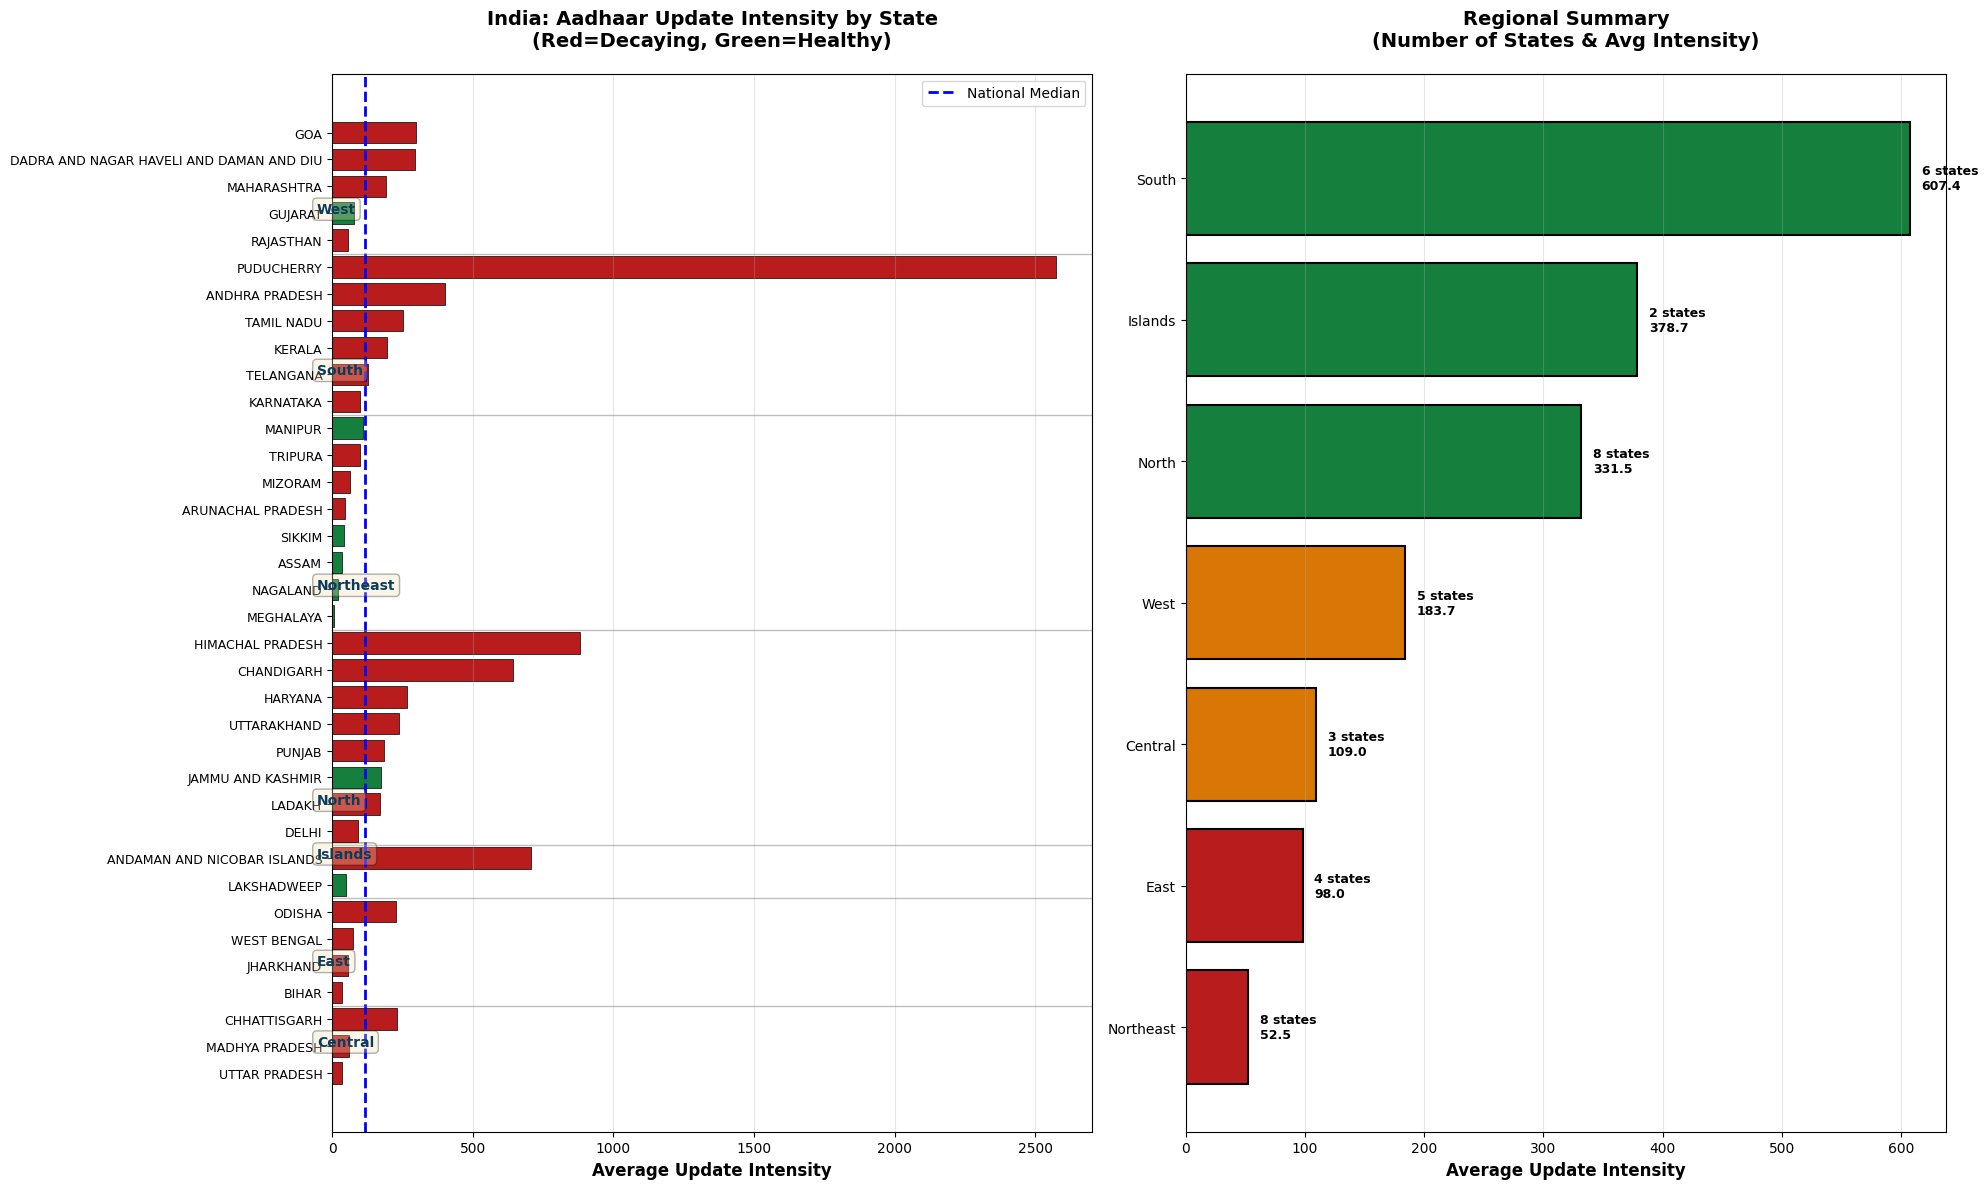


✅ India state visualization saved to: ../data/india_state_visualization.png


In [4]:
# Create comprehensive India state visualization
# Sort by region and intensity
state_geo_sorted = state_geo.sort_values(['region', 'avg_update_intensity']).copy()

# FIXED: Create color column with explicit type and no NaN possibility
def assign_color(row):
    """Assign color based on state status, guaranteed no NaN."""
    status = row['state_status']
    if status == 'DECAYING':
        return '#b91c1c'
    elif status == 'HEALTHY':
        return '#15803d'
    elif status == 'STAGNANT':
        return '#64748B'
    else:
        return '#9CA3AF'  # Default gray for any unexpected value

state_geo_sorted['color'] = state_geo_sorted.apply(assign_color, axis=1)

# Verify no NaN colors
print(f"States with NaN colors: {state_geo_sorted['color'].isna().sum()}")
print(f"Total states: {len(state_geo_sorted)}")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

# Plot 1: All states colored by status
colors_list = state_geo_sorted['color'].values  # Use .values for numpy array

bars1 = ax1.barh(
    range(len(state_geo_sorted)), 
    state_geo_sorted['avg_update_intensity'].values,
    color=colors_list,
    edgecolor='black',
    linewidth=0.5
)

ax1.set_yticks(range(len(state_geo_sorted)))
ax1.set_yticklabels(state_geo_sorted['state'].values, fontsize=9)
ax1.set_xlabel('Average Update Intensity', fontsize=12, fontweight='bold')
ax1.set_title('India: Aadhaar Update Intensity by State\n(Red=Decaying, Green=Healthy)', 
              fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3)
ax1.axvline(x=state_geo['avg_update_intensity'].median(), 
            color='blue', linestyle='--', linewidth=2, label='National Median')
ax1.legend()

# Add region separators
region_starts = {}
for idx, row in state_geo_sorted.reset_index().iterrows():
    if row['region'] not in region_starts:
        region_starts[row['region']] = idx

for region, start_idx in region_starts.items():
    if start_idx > 0:
        ax1.axhline(y=start_idx - 0.5, color='gray', linestyle='-', linewidth=1, alpha=0.5)
    ax1.text(-0.02, start_idx + 1, region, transform=ax1.get_yaxis_transform(),
             fontsize=10, fontweight='bold', color='#0B3C5D', 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

# Plot 2: Regional summary
regional_summary = state_geo.groupby('region').agg({
    'avg_update_intensity': 'mean',
    'state': 'count'
}).reset_index()
regional_summary.columns = ['region', 'avg_intensity', 'num_states']
regional_summary = regional_summary.sort_values('avg_intensity')

region_colors = ['#b91c1c' if x < 100 else '#D97706' if x < 200 else '#15803d' 
                 for x in regional_summary['avg_intensity']]

bars2 = ax2.barh(regional_summary['region'], 
                 regional_summary['avg_intensity'],
                 color=region_colors,
                 edgecolor='black',
                 linewidth=1.5)

for i, (idx, row) in enumerate(regional_summary.iterrows()):
    ax2.text(row['avg_intensity'] + 10, i, 
             f"{int(row['num_states'])} states\n{row['avg_intensity']:.1f}",
             va='center', fontsize=9, fontweight='bold')

ax2.set_xlabel('Average Update Intensity', fontsize=12, fontweight='bold')
ax2.set_title('Regional Summary\n(Number of States & Avg Intensity)', 
              fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/india_state_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ India state visualization saved to: ../data/india_state_visualization.png")

## Section 5: Interactive Plotly Visualization

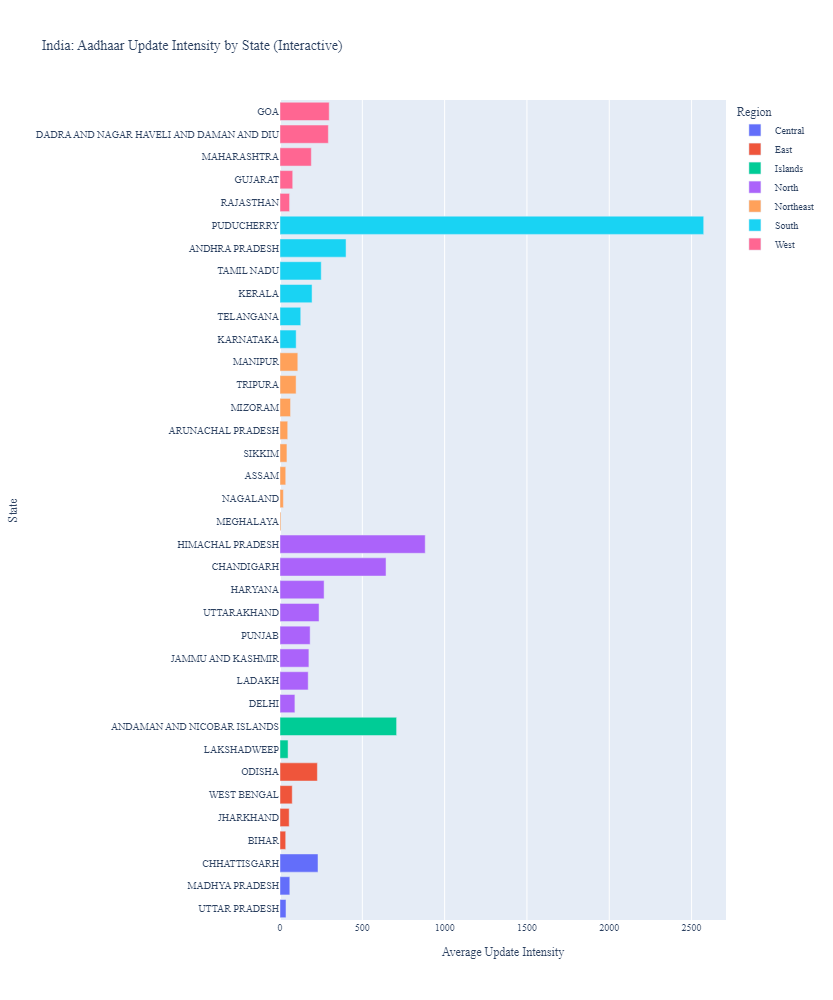

✅ Interactive visualization saved to: ../data/india_interactive_map.html


In [5]:
# Create interactive Plotly visualization
state_geo_sorted_plotly = state_geo.sort_values('avg_update_intensity')

fig = go.Figure()

# Add bars colored by region
for region in sorted(state_geo['region'].unique()):
    region_data = state_geo_sorted_plotly[state_geo_sorted_plotly['region'] == region]
    
    fig.add_trace(go.Bar(
        y=region_data['state'],
        x=region_data['avg_update_intensity'],
        name=region,
        orientation='h',
        hovertemplate='<b>%{y}</b><br>' +
                      'Update Intensity: %{x:.2f}<br>' +
                      'Status: ' + region_data['state_status'].astype(str) + '<br>' +
                      'Priority Rank: #' + region_data['priority_rank'].astype(int).astype(str) +
                      '<extra></extra>'
    ))

fig.update_layout(
    title='India: Aadhaar Update Intensity by State (Interactive)',
    xaxis_title='Average Update Intensity',
    yaxis_title='State',
    height=1000,
    showlegend=True,
    legend=dict(
        title='Region',
        orientation='v',
        yanchor='top',
        y=1,
        xanchor='left',
        x=1.02
    ),
    font=dict(family='Inter', size=10),
    hovermode='closest'
)

fig.write_html('../data/india_interactive_map.html')
fig.show()

print("✅ Interactive visualization saved to: ../data/india_interactive_map.html")

## Section 6: Regional Analysis
### Statistical comparison across regions

In [6]:
# Regional aggregates
regional_stats = state_geo.groupby('region').agg({
    'avg_update_intensity': ['mean', 'std', 'min', 'max'],
    'total_updates': 'sum',
    'state': 'count'
}).reset_index()

regional_stats.columns = ['region', 'mean_intensity', 'std_intensity', 
                           'min_intensity', 'max_intensity', 'total_updates', 'num_states']
regional_stats = regional_stats.sort_values('mean_intensity')

print("\nRegional Performance Summary:")
print("="*80)
print(regional_stats.to_string(index=False))
print("="*80)

# Identify best and worst regions (excluding 'Other')
regional_stats_filtered = regional_stats[regional_stats['region'] != 'Other']

if len(regional_stats_filtered) > 0:
    best_region = regional_stats_filtered.iloc[-1]
    worst_region = regional_stats_filtered.iloc[0]
    
    print(f"\n🏆 Best Performing Region: {best_region['region']}")
    print(f"   Average Intensity: {best_region['mean_intensity']:.2f}")
    print(f"   States: {int(best_region['num_states'])}")
    
    print(f"\n⚠️  Lowest Performing Region: {worst_region['region']}")
    print(f"   Average Intensity: {worst_region['mean_intensity']:.2f}")
    print(f"   States: {int(worst_region['num_states'])}")


Regional Performance Summary:
   region  mean_intensity  std_intensity  min_intensity  max_intensity  total_updates  num_states
Northeast       52.513953      35.720674       5.749409     108.182366      3645224.0           8
     East       97.984774      87.592234      34.698321     227.104458     23022431.0           4
  Central      108.955663     106.194319      36.381196     230.840463     31610935.0           3
     West      183.662883     114.593684      58.108585     298.946646     26223847.0           5
    North      331.467209     278.761146      90.489004     882.116229     11307639.0           8
  Islands      378.677602     466.180143      49.038462     708.316742        30497.0           2
    South      607.358203     969.243932      98.185254    2573.587609     23041668.0           6

🏆 Best Performing Region: South
   Average Intensity: 607.36
   States: 6

⚠️  Lowest Performing Region: Northeast
   Average Intensity: 52.51
   States: 8


## Section 7: Export Geo Data

In [7]:
# Save geographical analysis
state_geo.to_csv('../data/state_geographical_analysis.csv', index=False)
regional_stats.to_csv('../data/regional_summary.csv', index=False)

print("\n" + "="*60)
print("GEOGRAPHICAL ANALYSIS COMPLETE")
print("="*60)
print("✅ ../data/state_geographical_analysis.csv")
print("✅ ../data/regional_summary.csv")
print("✅ ../data/india_state_visualization.png")
print("✅ ../data/india_interactive_map.html")
print("="*60)


GEOGRAPHICAL ANALYSIS COMPLETE
✅ ../data/state_geographical_analysis.csv
✅ ../data/regional_summary.csv
✅ ../data/india_state_visualization.png
✅ ../data/india_interactive_map.html
